In [25]:
import re
import wandb
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 48)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

api = wandb.Api()
runs = api.runs("rap1ide/slice_inflate")

In [26]:
def get_agg_dict(filtered_frame):
    agg_dict = {
        n: 'first' if t != float else 'mean' for n,t in zip(filtered_frame.columns,filtered_frame.dtypes)
    }
    return agg_dict

# get n chunks of a list
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def join_cols(frame, first_col_key, second_col_key, join_str="+", drop_second=True):
    first_col = frame[first_col_key].astype(str)
    second_col = frame[second_col_key].astype(str)
    frame[first_col_key] = first_col + join_str + second_col
    if drop_second:
        frame.drop(second_col_key, axis=1, inplace=True)
    else:
        frame.drop(first_col_key, axis=1, inplace=True)
    return frame

In [27]:
def get_wanted_keys(phase):
    assert phase in ['val', 'test']

    wanted_keys = {
        '_id': '_id',
        'prescan_res': 'Precsan props.',
        # 'description': 'Description',
        'prescan_type': 'Prescan props.',
        'slice_res': 'Slice resolution',
        'slice_type': 'Slice props.',
        'first_view': 'Slice view(s)',
        'second_view': 'Second view',
        'fold': 'fold',
        f'scores/{phase}_mean_dice_MYO': 'MYO',
        f'scores/{phase}_mean_dice_LV': 'LV',
        f'scores/{phase}_mean_dice_RV': 'RV',
        f'scores/{phase}_mean_dice_LA': 'LA',
        f'scores/{phase}_mean_dice_RA': 'RA',

        f'scores/{phase}_mean_oa_exclude_bg_dice': '\multicolumn{1}{c}{$\mu\pm\sigma$ }',
        f'scores/{phase}_std_oa_exclude_bg_dice': 'N/A',

        f'scores/{phase}_mean_hd95_MYO': 'MYO',
        f'scores/{phase}_mean_hd95_LV': 'LV',
        f'scores/{phase}_mean_hd95_RV': 'RV',
        f'scores/{phase}_mean_hd95_LA': 'LA',
        f'scores/{phase}_mean_hd95_RA': 'RA',
        f'scores/{phase}_mean_oa_exclude_bg_hd95': '\multicolumn{1}{c}{$\mu\pm\sigma$  }',
        f'scores/{phase}_std_oa_exclude_bg_hd95': 'N/A',

        # 'scores/val_mean_oa_exclude_bg_iou': 'IOU',
        # 'scores/val_std_oa_exclude_bg_iou': '',

        f'scores/{phase}_mean_delta_vol_rel_LV': '\multicolumn{1}{c}{$\mu\pm\sigma$}   ',
        f'scores/{phase}_std_delta_vol_rel_LV': '',
    }
    return wanted_keys

In [28]:
recent_mmwhs_runs = list(filter(lambda r:
                          r.name.startswith("202402")
                          and 'meta_config_id' in r.config
                          and isinstance(r.config['meta_config_id'], int)
                          and r.config['dataset'][0] == 'mmwhs', runs))

mmwhs_runs = [dict(name=f"dummy{idx:02d}") for idx in range(0,48)]

for run_idx in range(len(mmwhs_runs)):
    meta_config_id = int(run_idx // 3)
    fold_idx = run_idx % 3
    if meta_config_id in [9,11,13,15]:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-opt_both_fix' in r.name,
            recent_mmwhs_runs))
    else:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-ref' in r.name,
            recent_mmwhs_runs))

    if len(wandb_runs) > 1:
        raise ValueError(f"Expected exactly one run, got {len(wandb_runs)}")
    elif len(wandb_runs) == 0:
        continue

    run = wandb_runs[0]
    name = run.name
    path = run.path
    meta_config_id = run.config['meta_config_id']

    fold_idx = int(re.match(r'.*fold-(\d+).*', name).group(1))
    entry = dict(
        name=name,
        id=meta_config_id,
        fold=fold_idx,
        access_key='/'.join(path),
    )
    mmwhs_runs[run_idx] = entry

import json
with open('mmwhs_runs.json', 'w') as f:
    json.dump(mmwhs_runs, f, indent=4)

In [29]:
settings = {
   "0:1": dict(description="Clinical standard",
      first_view="p2CH",
      second_view="p4CH",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "1:2": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "2:3": dict(description="Clinical standard",
      first_view="2CH",
      second_view="SA",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "3:9": dict(description="Mean out of 6 Random",
      first_view="RND",
      second_view="RND",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "9:10": dict(description="Optimized",
      first_view="OPT",
      second_view="OPT",
      prescan_res ="$(1.5mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),

   "10:11": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(6mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),
   "11:12": dict(description="Optimized",
      first_view="OPT",
      second_view="OPT",
      prescan_res ="$(6mm)^3$",
      prescan_type ="GT",
      slice_res ="$(1.5mm)^2$",
      slice_type="GT",
   ),

   "12:13": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(1.5mm)^2$",
      slice_type="SEG",
   ),
   "13:14": dict(description="Optimized",
      first_view="OPT",
      second_view="OPT",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(1.5mm)^2$",
      slice_type="SEG",
   ),

   "14:15": dict(description="Clinical standard",
      first_view="2CH",
      second_view="4CH",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(6mm)^3$",
      slice_type="SEG",
   ),
   "15:16": dict(description="Optimized",
      first_view="OPT",
      second_view="OPT",
      prescan_res ="$(6mm)^3$",
      prescan_type ="SEG",
      slice_res ="$(6mm)^3$",
      slice_type="SEG",
   ),
}

# Build latex tables

## Build latex table for MMWHS

In [30]:
df = pd.DataFrame()

for run_idx, rr in enumerate(mmwhs_runs):
   wandb_run_name = rr['name']
   run_frame = pd.DataFrame()
   run_numeric_id = run_idx // 3
   try:
      run_key = rr['access_key']
      wrun = api.run(run_key)
      run_frame = pd.DataFrame(wrun.history())
      run_frame = run_frame.iloc[-1:]
      run_frame.index = [run_idx]

   except:
      print(f"Failed to fetch run {wandb_run_name}")
      run_frame = run_frame.map(lambda x: np.nan)

   if 3 <= run_numeric_id < 9:
      run_settings = settings['3:9']
   else:
      run_settings = settings[f"{run_numeric_id}:{run_numeric_id+1}"]

   run_frame.insert(0, '_id', [run_numeric_id])
   run_frame.insert(1, 'description', [run_settings['description']])
   run_frame.insert(2, 'first_view', run_settings['first_view'])
   run_frame.insert(3, 'second_view', run_settings['second_view'])
   run_frame.insert(4, 'prescan_res', run_settings['prescan_res'])
   run_frame.insert(5, 'prescan_type', run_settings['prescan_type'])
   run_frame.insert(6, 'slice_res', run_settings['slice_res'])
   run_frame.insert(7, 'slice_type', run_settings['slice_type'])
   fold_idx = run_idx % 3
   run_frame.insert(8, 'fold', fold_idx)

   df = pd.concat([df,run_frame])

df = df.fillna(0)

In [31]:
df

,_id,description,first_view,second_view,prescan_res,prescan_type,slice_res,slice_type,fold,scores/val_std_delta_vol_rel_RA,...,orientations/val_sa_theta_t_offsets1_mean,orientations/test_hla_theta_ap4_mean,orientations/train_sa_theta_t_offsets2_std,orientations/train_hla_theta_ap3_std,orientations/train_sa_theta_ap4_mean,orientations/train_hla_theta_ap1_std,orientations/test_sa_theta_ap2_std,orientations/test_hla_theta_t_offsets1_mean,orientations/train_hla_theta_ap2_mean,orientations/train_sa_theta_ap5_std
0,0,Clinical standard,p2CH,p4CH,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,0,0.082965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,Clinical standard,p2CH,p4CH,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,1,0.208663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,Clinical standard,p2CH,p4CH,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2,0.341970,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,Clinical standard,2CH,4CH,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,0,0.244374,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,Clinical standard,2CH,4CH,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,1,0.117860,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1,Clinical standard,2CH,4CH,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2,0.168998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2,Clinical standard,2CH,SA,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,0,0.213786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2,Clinical standard,2CH,SA,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,1,0.441933,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2,Clinical standard,2CH,SA,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2,0.239835,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,3,Mean out of 6 Random,RND,RND,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,0,0.183877,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
filtered_frame = df.copy()
FIRST_FOLD_ONLY = True
if FIRST_FOLD_ONLY:
    filtered_frame = filtered_frame[filtered_frame['fold'] == 0]
else:
    filtered_frame = filtered_frame.groupby('_id').agg(get_agg_dict(filtered_frame)) # TODO readd

# Prepare values
wanted_keys = get_wanted_keys('val')
filtered_frame = filtered_frame[wanted_keys.keys()]
filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/val_mean_dice_MYO,scores/val_mean_dice_LV,...,scores/val_std_oa_exclude_bg_dice,scores/val_mean_hd95_MYO,scores/val_mean_hd95_LV,scores/val_mean_hd95_RV,scores/val_mean_hd95_LA,scores/val_mean_hd95_RA,scores/val_mean_oa_exclude_bg_hd95,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_delta_vol_rel_LV,scores/val_std_delta_vol_rel_LV
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,0.787386,0.882927,...,0.161880,7.653829,8.184327,30.340399,27.579405,38.687687,22.489130,25.385578,0.165246,0.148523
3,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,0.818286,0.886840,...,0.094747,6.848581,8.203704,19.513845,8.874496,27.100212,14.108168,10.160501,0.170663,0.193362
6,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,0.799069,0.876908,...,0.121211,7.778636,10.233290,16.517567,13.801551,31.586577,15.983524,10.033892,0.143610,0.107447
9,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,0.734541,0.835747,...,0.081127,10.942106,13.641310,15.786133,11.707310,20.966076,14.608587,5.689139,0.276734,0.306709
12,4,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,0.668667,0.809187,...,0.092047,11.198994,13.932410,13.815671,13.440009,22.444048,14.966227,5.608179,0.332480,0.412373
15,5,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,0.679266,0.814930,...,0.090776,12.473555,14.390116,14.227982,11.209965,20.762866,14.612897,5.549861,0.278786,0.287378
18,6,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,0.747566,0.843451,...,0.092904,11.047014,12.633115,20.883607,20.635929,13.446682,15.729270,6.948728,0.283455,0.304741
21,7,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,0.678732,0.819600,...,0.102870,13.699623,13.779130,26.264427,36.324304,41.979591,26.409415,30.877003,0.296043,0.357756
24,8,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,0.651022,0.802227,...,0.093950,12.886364,14.939037,16.904418,15.464254,19.790938,15.997002,5.558770,0.357191,0.400342
27,9,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,OPT,OPT,0,0.796883,0.878357,...,0.065265,8.635031,9.707458,15.107641,13.817688,12.129762,11.879516,3.890873,0.157118,0.184553


In [33]:
percent_keys = [k for k in wanted_keys if "dice" in k or "vol_rel" in k]
mean_keys = [k for k in wanted_keys if "mean" in k]
min_metrics_keys = [k for k in wanted_keys if ("delta" in k or "hd" in k) and not 'std' in k]
max_metrics_keys = [k for k in wanted_keys if ("dice" in k or "iou" in k) and not 'std' in k]
filtered_frame.loc[:,percent_keys] *= 100.

# Aggregate random runs to build mean
random_runs = list(range(0,3)) + 6 * ['is_random'] + list(range(9,16))
filtered_frame.insert(1, 'is_random', random_runs)
filtered_frame = filtered_frame.groupby('is_random', as_index=False).agg(get_agg_dict(filtered_frame))

reindex_idx = list(range(0,3)) + [-1] + list(range(3,10))
filtered_frame = filtered_frame.iloc[reindex_idx,:]
filtered_frame.drop('is_random', axis=1, inplace=True)

filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/val_mean_dice_MYO,scores/val_mean_dice_LV,...,scores/val_std_oa_exclude_bg_dice,scores/val_mean_hd95_MYO,scores/val_mean_hd95_LV,scores/val_mean_hd95_RV,scores/val_mean_hd95_LA,scores/val_mean_hd95_RA,scores/val_mean_oa_exclude_bg_hd95,scores/val_std_oa_exclude_bg_hd95,scores/val_mean_delta_vol_rel_LV,scores/val_std_delta_vol_rel_LV
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,78.738603,88.292696,...,16.188044,7.653829,8.184327,30.340399,27.579405,38.687687,22.489130,25.385578,16.524597,14.852262
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,81.828588,88.684019,...,9.474719,6.848581,8.203704,19.513845,8.874496,27.100212,14.108168,10.160501,17.066317,19.336211
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,0,79.906897,87.690754,...,12.121097,7.778636,10.233290,16.517567,13.801551,31.586577,15.983524,10.033892,14.360977,10.744652
10,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,69.329900,82.085699,...,9.227907,12.041276,13.885853,17.980373,18.130295,23.231700,17.053899,10.038613,30.411486,34.488311
3,9,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,OPT,OPT,0,79.688274,87.835688,...,6.526484,8.635031,9.707458,15.107641,13.817688,12.129762,11.879516,3.890873,15.711795,18.455316
4,10,$(6mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,0,81.008878,89.431286,...,8.628087,7.543268,8.092771,18.864174,10.964181,22.749193,13.642718,9.240935,13.829095,11.850469
5,11,$(6mm)^3$,GT,$(1.5mm)^2$,GT,OPT,OPT,0,77.132856,86.147490,...,9.302832,8.884485,10.234073,14.758399,16.161725,14.386402,12.885017,7.179926,21.037749,31.941642
6,12,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,2CH,4CH,0,54.790481,74.604646,...,24.203818,19.327233,24.144426,45.827422,91.457761,122.673572,60.686083,52.851945,27.921899,28.358856
7,13,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,OPT,OPT,0,43.473331,64.699265,...,21.734559,47.706876,49.442194,43.386145,89.343131,48.058367,55.587343,34.292567,61.605835,81.328667
8,14,$(6mm)^3$,SEG,$(6mm)^3$,SEG,2CH,4CH,0,49.946244,69.064037,...,26.189779,24.859984,26.133893,41.719390,112.498095,98.864275,60.815127,49.544856,42.982771,39.311175


In [34]:
# Get bold values (best)
group_ranges = [
    [0,5],
    [5,7],
    [7,9],
    [9,11],
]

bold_idxs = []
for sub_range in group_ranges:
    sub_frame = filtered_frame.iloc[sub_range[0]:sub_range[1]]
    optimal_vals_maximize = sub_frame[max_metrics_keys].idxmax()
    optimal_vals_minimize = sub_frame[min_metrics_keys].idxmin()

    bold_idxs.append(optimal_vals_maximize)
    bold_idxs.append(optimal_vals_minimize)

In [35]:
# Round and convert
filtered_frame = filtered_frame.round(decimals=1)
string_frame = filtered_frame.copy().astype(str)

# Fuse mean and std columns
for m in mean_keys:
    mean_col = string_frame[m].astype(str)
    std_col_key = m.replace("mean","std")
    if std_col_key in string_frame.columns:
        std_col = string_frame[std_col_key].astype(str)
        string_frame[m] = mean_col + r" \pm " + std_col
        string_frame.drop(std_col_key, axis=1, inplace=True)

# Add bold to optimal values
for bold_group in bold_idxs:
    for col_name, idx in zip(bold_group.index, bold_group.values):
        row_idx = string_frame.index.get_loc(idx)
        col_idx = string_frame.columns.get_loc(col_name)
        string_frame.iloc[row_idx,col_idx] = r"\B " + string_frame.iloc[row_idx,col_idx]

# Join first and second view
string_frame = join_cols(string_frame, 'first_view', 'second_view', join_str=r"+")
string_frame = join_cols(string_frame, 'prescan_type', 'prescan_res', join_str=r" ", drop_second=True)
string_frame = join_cols(string_frame, 'slice_type', 'slice_res', join_str=r" ", drop_second=True)

# Replace column names
string_frame.columns = [wanted_keys[c] for c in string_frame.columns]

# Drop and insert spacer columns
string_frame.drop('_id', axis=1, inplace=True)
string_frame.drop('fold', axis=1, inplace=True)

string_frame.insert(3, ' ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(10, '  ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(17, '   ', len(string_frame)*["\hspace{1pt}"])

# Add offset to groups in latex
for group_idxs in group_ranges[:-1]:
    txt = string_frame.iloc[group_idxs[1],0]
    string_frame.iloc[group_idxs[1],0] = r"\rule{0pt}{4ex} "+txt

string_frame

,Prescan props.,Slice props.,Slice view(s),,MYO,LV,RV,LA,RA,\multicolumn{1}{c}{$\mu\pm\sigma$ },,MYO,LV,RV,LA,RA,\multicolumn{1}{c}{$\mu\pm\sigma$ },,\multicolumn{1}{c}{$\mu\pm\sigma$}
0,GT $(1.5mm)^3$,GT $(1.5mm)^2$,p2CH+p4CH,\hspace{1pt},78.7,88.3,69.4,75.7,65.4,75.5 \pm 16.2,\hspace{1pt},7.7,\B 8.2,30.3,27.6,38.7,22.5 \pm 25.4,\hspace{1pt},16.5 \pm 14.9
1,GT $(1.5mm)^3$,GT $(1.5mm)^2$,2CH+4CH,\hspace{1pt},\B 81.8,\B 88.7,77.2,\B 86.5,74.9,81.8 \pm 9.5,\hspace{1pt},\B 6.8,8.2,19.5,\B 8.9,27.1,14.1 \pm 10.2,\hspace{1pt},17.1 \pm 19.3
2,GT $(1.5mm)^3$,GT $(1.5mm)^2$,2CH+SA,\hspace{1pt},79.9,87.7,77.0,79.7,61.3,77.1 \pm 12.1,\hspace{1pt},7.8,10.2,16.5,13.8,31.6,16.0 \pm 10.0,\hspace{1pt},\B 14.4 \pm 10.7
10,GT $(1.5mm)^3$,GT $(1.5mm)^2$,RND+RND,\hspace{1pt},69.3,82.1,\B 80.4,78.0,75.5,77.1 \pm 9.2,\hspace{1pt},12.0,13.9,18.0,18.1,23.2,17.1 \pm 10.0,\hspace{1pt},30.4 \pm 34.5
3,GT $(1.5mm)^3$,GT $(1.5mm)^2$,OPT+OPT,\hspace{1pt},79.7,87.8,79.8,81.1,\B 85.0,\B 82.7 \pm 6.5,\hspace{1pt},8.6,9.7,\B 15.1,13.8,\B 12.1,\B 11.9 \pm 3.9,\hspace{1pt},15.7 \pm 18.5
4,\rule{0pt}{4ex} GT $(6mm)^3$,GT $(1.5mm)^2$,2CH+4CH,\hspace{1pt},\B 81.0,\B 89.4,78.9,\B 85.2,76.4,\B 82.2 \pm 8.6,\hspace{1pt},\B 7.5,\B 8.1,18.9,\B 11.0,22.7,13.6 \pm 9.2,\hspace{1pt},\B 13.8 \pm 11.9
5,GT $(6mm)^3$,GT $(1.5mm)^2$,OPT+OPT,\hspace{1pt},77.1,86.1,\B 81.0,81.3,\B 81.1,81.3 \pm 9.3,\hspace{1pt},8.9,10.2,\B 14.8,16.2,\B 14.4,\B 12.9 \pm 7.2,\hspace{1pt},21.0 \pm 31.9
6,\rule{0pt}{4ex} SEG $(6mm)^3$,SEG $(1.5mm)^2$,2CH+4CH,\hspace{1pt},\B 54.8,\B 74.6,\B 60.3,26.8,23.8,48.1 \pm 24.2,\hspace{1pt},\B 19.3,\B 24.1,45.8,91.5,122.7,60.7 \pm 52.9,\hspace{1pt},\B 27.9 \pm 28.4
7,SEG $(6mm)^3$,SEG $(1.5mm)^2$,OPT+OPT,\hspace{1pt},43.5,64.7,54.5,\B 32.1,\B 58.1,\B 50.6 \pm 21.7,\hspace{1pt},47.7,49.4,\B 43.4,\B 89.3,\B 48.1,\B 55.6 \pm 34.3,\hspace{1pt},61.6 \pm 81.3
8,\rule{0pt}{4ex} SEG $(6mm)^3$,SEG $(6mm)^3$,2CH+4CH,\hspace{1pt},49.9,69.1,57.1,21.9,23.3,44.3 \pm 26.2,\hspace{1pt},\B 24.9,\B 26.1,41.7,112.5,98.9,60.8 \pm 49.5,\hspace{1pt},43.0 \pm 39.3


In [36]:
# Save to latex

PM_COL_FORMAT = "S[table-figures-decimal=1,separate-uncertainty=true,table-format=3.1(3)]"
COL_FORMAT = \
    ("c" * 9) \
    + PM_COL_FORMAT \
    + ("c" * 6) \
    + PM_COL_FORMAT \
    + "c" \
    + PM_COL_FORMAT
# 19 cols

header = [r'\multicolumn{3}{c}{\textbf{Experiment I}}'] \
    + 2*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{Dice in \% $\uparrow$}}'] + 5*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 5*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\textbf{$\Delta$vol LV in \% $\downarrow$}']

latex_frame = pd.concat([pd.DataFrame(header, index=string_frame.columns).T, string_frame])

latex_frame.to_latex(
    buf="mmwhs_results.txt",
    escape=False,
    column_format=COL_FORMAT,
    index=False,
)

# Load latex file and replace & NaN with &
with open("mmwhs_results.txt", "r") as f:
    lines = f.readlines()

    lines = [l.replace("& NaN", "") for l in lines]

with open("mmwhs_results.txt", "w") as f:
    f.writelines(lines)

# Insert 5th line before third line
with open("mmwhs_results.txt", "r") as f:
    lines = f.readlines()
    lines.insert(2, lines[4])
    del lines[5]
with open("mmwhs_results.txt", "w") as f:
    f.writelines(lines)

# Build latex table for MRXCAT

In [37]:
recent_mrxcat_runs = list(filter(lambda r:
                          r.name.startswith("202402")
                          and 'meta_config_id' in r.config
                          and isinstance(r.config['meta_config_id'], int)
                          and r.config['dataset'][0] == 'mrxcat', runs))

mrxcat_runs = [dict(name=f"dummy{idx:02d}") for idx in range(0,16)]

for run_idx in range(len(mrxcat_runs)):
    meta_config_id = run_idx
    fold_idx = 0
    if meta_config_id in [9,11,13,15]:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-opt_both_fix' in r.name,
            recent_mrxcat_runs))
    else:
        wandb_runs = list(filter(lambda r: f"fold-{fold_idx}" in r.name
            and 'meta_config_id' in r.config
            and r.config['meta_config_id'] == meta_config_id
            and '-ref' in r.name,
            recent_mrxcat_runs))

    if len(wandb_runs) > 1:
        raise ValueError(f"Expected exactly one run, got {len(wandb_runs)}")
    elif len(wandb_runs) == 0:
        continue

    run = wandb_runs[0]
    name = run.name
    path = run.path
    meta_config_id = run.config['meta_config_id']

    fold_idx = int(re.match(r'.*fold-(\d+).*', name).group(1))
    entry = dict(
        name=name,
        id=meta_config_id,
        fold=fold_idx,
        access_key='/'.join(path),
    )
    mrxcat_runs[run_idx] = entry


In [38]:
df = pd.DataFrame()

for run_idx, rr in enumerate(mrxcat_runs):
   wandb_run_name = rr['name']
   run_frame = pd.DataFrame()
   run_numeric_id = run_idx
   try:
      run_key = rr['access_key']
      wrun = api.run(run_key)
      run_frame = pd.DataFrame(wrun.history())
      run_frame = run_frame.iloc[-1:]
      run_frame.index = [run_idx]

   except:
      print(f"Failed to fetch run {wandb_run_name}")
      run_frame = run_frame.map(lambda x: np.nan)

   if 3 <= run_numeric_id < 9:
      run_settings = settings['3:9']
   else:
      run_settings = settings[f"{run_numeric_id}:{run_numeric_id+1}"]

   run_frame.insert(0, '_id', [run_numeric_id])
   run_frame.insert(1, 'description', [run_settings['description']])
   run_frame.insert(2, 'first_view', run_settings['first_view'])
   run_frame.insert(3, 'second_view', run_settings['second_view'])
   run_frame.insert(4, 'prescan_res', run_settings['prescan_res'])
   run_frame.insert(5, 'prescan_type', run_settings['prescan_type'])
   run_frame.insert(6, 'slice_res', run_settings['slice_res'])
   run_frame.insert(7, 'slice_type', run_settings['slice_type'])
   fold_idx = run_idx % 3
   run_frame.insert(8, 'fold', fold_idx)

   df = pd.concat([df,run_frame])

df = df.fillna(0)

In [39]:
filtered_frame = df.copy()
filtered_frame = filtered_frame.groupby('_id').agg(get_agg_dict(filtered_frame))

wanted_keys = get_wanted_keys('test') # Use test here for MRXCAT

In [40]:
# Prepare values
filtered_frame = filtered_frame[wanted_keys.keys()]

percent_keys = [k for k in wanted_keys if "dice" in k or "vol_rel" in k]
mean_keys = [k for k in wanted_keys if "mean" in k]
min_metrics_keys = [k for k in wanted_keys if ("delta" in k or "hd" in k) and not 'std' in k]
max_metrics_keys = [k for k in wanted_keys if ("dice" in k or "iou" in k) and not 'std' in k]
filtered_frame.loc[:,percent_keys] *= 100.

# Aggregate random runs to build mean
random_runs = list(range(0,3)) + 6 * ['is_random'] + list(range(9,16))
filtered_frame.insert(1, 'is_random', random_runs)
filtered_frame = filtered_frame.groupby('is_random', as_index=False).agg(get_agg_dict(filtered_frame))

reindex_idx = list(range(0,3)) + [-1] + list(range(3,10))
filtered_frame = filtered_frame.iloc[reindex_idx,:]
filtered_frame.drop('is_random', axis=1, inplace=True)

filtered_frame

,_id,prescan_res,prescan_type,slice_res,slice_type,first_view,second_view,fold,scores/test_mean_dice_MYO,scores/test_mean_dice_LV,...,scores/test_std_oa_exclude_bg_dice,scores/test_mean_hd95_MYO,scores/test_mean_hd95_LV,scores/test_mean_hd95_RV,scores/test_mean_hd95_LA,scores/test_mean_hd95_RA,scores/test_mean_oa_exclude_bg_hd95,scores/test_std_oa_exclude_bg_hd95,scores/test_mean_delta_vol_rel_LV,scores/test_std_delta_vol_rel_LV
0,0,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,p2CH,p4CH,0,82.365680,89.962780,...,8.480595,6.216542,5.278699,11.863046,5.275022,13.879671,8.502596,14.723121,19.395498,14.357763
1,1,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,1,79.869457,86.764754,...,5.884246,6.535374,7.082328,7.967608,5.066294,7.699234,6.870168,1.995381,30.629576,19.055006
2,2,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,2CH,SA,2,79.310299,86.509711,...,6.231887,6.525092,7.173643,8.562159,6.906519,8.688477,7.571178,2.624240,31.524916,23.117174
10,3,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,RND,RND,0,78.885249,86.323227,...,6.984976,7.231893,8.436540,9.576620,7.975446,6.873489,8.018798,5.368297,30.909936,21.359366
3,9,$(1.5mm)^3$,GT,$(1.5mm)^2$,GT,OPT,OPT,0,80.661790,87.785348,...,5.418078,6.275527,6.618766,7.120701,4.632753,6.271313,6.183812,1.970672,27.282583,18.599704
4,10,$(6mm)^3$,GT,$(1.5mm)^2$,GT,2CH,4CH,1,79.127998,86.909891,...,6.651285,6.342387,7.252972,10.285381,5.142408,7.575159,7.319661,2.976584,29.929758,19.653570
5,11,$(6mm)^3$,GT,$(1.5mm)^2$,GT,OPT,OPT,2,78.697366,85.706467,...,5.967787,6.760223,7.167126,6.806104,6.628123,7.402554,6.952826,1.815409,33.093803,23.221983
6,12,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,2CH,4CH,0,68.602278,82.099271,...,8.000468,10.341926,10.169448,31.703254,7.319977,7.730377,13.452997,17.400824,42.286111,25.242616
7,13,$(6mm)^3$,SEG,$(1.5mm)^2$,SEG,OPT,OPT,1,69.880948,81.774322,...,8.733575,9.377438,9.789072,9.985831,11.707005,7.658923,9.703654,2.971459,44.103078,30.057787
8,14,$(6mm)^3$,SEG,$(6mm)^3$,SEG,2CH,4CH,2,67.375544,81.567824,...,7.850007,9.901599,8.897509,10.396655,7.748734,9.669344,9.322768,1.971846,45.228122,21.502644


In [41]:
# Get bold values (best)
group_ranges = [
    [0,5],
    [5,7],
    [7,9],
    [9,11],
]

bold_idxs = []
for sub_range in group_ranges:
    sub_frame = filtered_frame.iloc[sub_range[0]:sub_range[1]]
    optimal_vals_maximize = sub_frame[max_metrics_keys].idxmax()
    optimal_vals_minimize = sub_frame[min_metrics_keys].idxmin()

    bold_idxs.append(optimal_vals_maximize)
    bold_idxs.append(optimal_vals_minimize)

In [42]:
# Round and convert
filtered_frame = filtered_frame.round(decimals=1)
string_frame = filtered_frame.copy().astype(str)

# Fuse mean and std columns
for m in mean_keys:
    mean_col = string_frame[m].astype(str)
    std_col_key = m.replace("mean","std")
    if std_col_key in string_frame.columns:
        std_col = string_frame[std_col_key].astype(str)
        string_frame[m] = mean_col + r" \pm " + std_col
        string_frame.drop(std_col_key, axis=1, inplace=True)

# Add bold to optimal values
for bold_group in bold_idxs:
    for col_name, idx in zip(bold_group.index, bold_group.values):
        row_idx = string_frame.index.get_loc(idx)
        col_idx = string_frame.columns.get_loc(col_name)
        string_frame.iloc[row_idx,col_idx] = r"\B " + string_frame.iloc[row_idx,col_idx]

# Join first and second view
string_frame = join_cols(string_frame, 'first_view', 'second_view', join_str=r"+")
string_frame = join_cols(string_frame, 'prescan_type', 'prescan_res', join_str=r" ", drop_second=True)
string_frame = join_cols(string_frame, 'slice_type', 'slice_res', join_str=r" ", drop_second=True)

# Replace column names
string_frame.columns = [wanted_keys[c] for c in string_frame.columns]

# Drop and insert spacer columns
string_frame.drop('_id', axis=1, inplace=True)
string_frame.drop('fold', axis=1, inplace=True)

string_frame.insert(3, ' ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(10, '  ', len(string_frame)*["\hspace{1pt}"])
string_frame.insert(17, '   ', len(string_frame)*["\hspace{1pt}"])

# Add offset to groups in latex
for group_idxs in group_ranges[:-1]:
    txt = string_frame.iloc[group_idxs[1],0]
    string_frame.iloc[group_idxs[1],0] = r"\rule{0pt}{4ex} "+txt

string_frame

,Prescan props.,Slice props.,Slice view(s),,MYO,LV,RV,LA,RA,\multicolumn{1}{c}{$\mu\pm\sigma$ },,MYO,LV,RV,LA,RA,\multicolumn{1}{c}{$\mu\pm\sigma$ },,\multicolumn{1}{c}{$\mu\pm\sigma$}
0,GT $(1.5mm)^3$,GT $(1.5mm)^2$,p2CH+p4CH,\hspace{1pt},\B 82.4,\B 90.0,84.2,90.6,83.4,86.1 \pm 8.5,\hspace{1pt},\B 6.2,\B 5.3,11.9,5.3,13.9,8.5 \pm 14.7,\hspace{1pt},\B 19.4 \pm 14.4
1,GT $(1.5mm)^3$,GT $(1.5mm)^2$,2CH+4CH,\hspace{1pt},79.9,86.8,83.5,90.7,85.2,85.2 \pm 5.9,\hspace{1pt},6.5,7.1,8.0,5.1,7.7,6.9 \pm 2.0,\hspace{1pt},30.6 \pm 19.1
2,GT $(1.5mm)^3$,GT $(1.5mm)^2$,2CH+SA,\hspace{1pt},79.3,86.5,83.9,88.6,82.9,84.2 \pm 6.2,\hspace{1pt},6.5,7.2,8.6,6.9,8.7,7.6 \pm 2.6,\hspace{1pt},31.5 \pm 23.1
10,GT $(1.5mm)^3$,GT $(1.5mm)^2$,RND+RND,\hspace{1pt},78.9,86.3,84.9,87.1,88.6,85.2 \pm 7.0,\hspace{1pt},7.2,8.4,9.6,8.0,6.9,8.0 \pm 5.4,\hspace{1pt},30.9 \pm 21.4
3,GT $(1.5mm)^3$,GT $(1.5mm)^2$,OPT+OPT,\hspace{1pt},80.7,87.8,\B 86.3,\B 91.0,\B 88.9,\B 86.9 \pm 5.4,\hspace{1pt},6.3,6.6,\B 7.1,\B 4.6,\B 6.3,\B 6.2 \pm 2.0,\hspace{1pt},27.3 \pm 18.6
4,\rule{0pt}{4ex} GT $(6mm)^3$,GT $(1.5mm)^2$,2CH+4CH,\hspace{1pt},\B 79.1,\B 86.9,80.7,\B 91.3,86.4,84.9 \pm 6.7,\hspace{1pt},\B 6.3,7.3,10.3,\B 5.1,7.6,7.3 \pm 3.0,\hspace{1pt},\B 29.9 \pm 19.7
5,GT $(6mm)^3$,GT $(1.5mm)^2$,OPT+OPT,\hspace{1pt},78.7,85.7,\B 87.3,88.7,\B 87.2,\B 85.5 \pm 6.0,\hspace{1pt},6.8,\B 7.2,\B 6.8,6.6,\B 7.4,\B 7.0 \pm 1.8,\hspace{1pt},33.1 \pm 23.2
6,\rule{0pt}{4ex} SEG $(6mm)^3$,SEG $(1.5mm)^2$,2CH+4CH,\hspace{1pt},68.6,\B 82.1,82.4,\B 86.0,85.9,\B 81.0 \pm 8.0,\hspace{1pt},10.3,10.2,31.7,\B 7.3,7.7,13.5 \pm 17.4,\hspace{1pt},\B 42.3 \pm 25.2
7,SEG $(6mm)^3$,SEG $(1.5mm)^2$,OPT+OPT,\hspace{1pt},\B 69.9,81.8,\B 84.0,76.4,\B 87.4,79.9 \pm 8.7,\hspace{1pt},\B 9.4,\B 9.8,\B 10.0,11.7,\B 7.7,\B 9.7 \pm 3.0,\hspace{1pt},44.1 \pm 30.1
8,\rule{0pt}{4ex} SEG $(6mm)^3$,SEG $(6mm)^3$,2CH+4CH,\hspace{1pt},67.4,\B 81.6,\B 81.0,\B 86.5,\B 82.4,\B 79.8 \pm 7.9,\hspace{1pt},\B 9.9,\B 8.9,\B 10.4,\B 7.7,\B 9.7,\B 9.3 \pm 2.0,\hspace{1pt},45.2 \pm 21.5


In [43]:
# Save to latex

PM_COL_FORMAT = "S[table-figures-decimal=1,separate-uncertainty=true,table-format=3.1(3)]"
COL_FORMAT = \
    ("c" * 9) \
    + PM_COL_FORMAT \
    + ("c" * 6) \
    + PM_COL_FORMAT \
    + "c" \
    + PM_COL_FORMAT
# 19 cols

header = [r'\multicolumn{3}{c}{\textbf{Experiment II}}'] \
    + 2*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{Dice in \% $\uparrow$}}'] + 5*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\multicolumn{6}{c}{\textbf{HD95 in mm $\downarrow$}}'] + 5*[None] \
    + [r'\hspace{1pt}'] \
    + [r'\textbf{$\Delta$vol LV in \% $\downarrow$}']

latex_frame = pd.concat([pd.DataFrame(header, index=string_frame.columns).T, string_frame])

latex_frame.to_latex(
    buf="mrxcat_results.txt",
    escape=False,
    column_format=COL_FORMAT,
    index=False,
)

# Load latex file and replace & NaN with &
with open("mrxcat_results.txt", "r") as f:
    lines = f.readlines()

    lines = [l.replace("& NaN", "") for l in lines]

with open("mrxcat_results.txt", "w") as f:
    f.writelines(lines)

# Insert 5th line before third line
with open("mrxcat_results.txt", "r") as f:
    lines = f.readlines()
    lines.insert(2, lines[4])
    del lines[5]
with open("mrxcat_results.txt", "w") as f:
    f.writelines(lines)

In [44]:
# read csv
import pandas as pd
df = pd.read_csv("/home/weihsbach/storage/staff/christianweihsbach/slice_inflate/visualize/wandb_export_2024-02-01T23_31_00.388+01_00.csv", sep=",")

In [45]:
df

,ref_epoch_idx,20240201__16_29_09_sleek-design_fold-1_stage-ref - _step,20240201__16_29_09_sleek-design_fold-1_stage-ref - _step__MIN,20240201__16_29_09_sleek-design_fold-1_stage-ref - _step__MAX,20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice,20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice__MIN,20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice__MAX,20240201__16_29_09_sleek-design_fold-1_stage-opt_both_fix - _step,20240201__16_29_09_sleek-design_fold-1_stage-opt_both_fix - _step__MIN,20240201__16_29_09_sleek-design_fold-1_stage-opt_both_fix - _step__MAX,...,20240201__16_29_09_sleek-design_fold-1_stage-opt_second - _step__MAX,20240201__16_29_09_sleek-design_fold-1_stage-opt_second - scores/val_mean_oa_exclude_bg_dice,20240201__16_29_09_sleek-design_fold-1_stage-opt_second - scores/val_mean_oa_exclude_bg_dice__MIN,20240201__16_29_09_sleek-design_fold-1_stage-opt_second - scores/val_mean_oa_exclude_bg_dice__MAX,20240201__16_29_09_sleek-design_fold-1_stage-opt_first - _step,20240201__16_29_09_sleek-design_fold-1_stage-opt_first - _step__MIN,20240201__16_29_09_sleek-design_fold-1_stage-opt_first - _step__MAX,20240201__16_29_09_sleek-design_fold-1_stage-opt_first - scores/val_mean_oa_exclude_bg_dice,20240201__16_29_09_sleek-design_fold-1_stage-opt_first - scores/val_mean_oa_exclude_bg_dice__MIN,20240201__16_29_09_sleek-design_fold-1_stage-opt_first - scores/val_mean_oa_exclude_bg_dice__MAX
0,0,100000,100000,100000,0.150597,0.150597,0.150597,100000,100000,100000,...,100000,0.132629,0.132629,0.132629,100000,100000,100000,0.149742,0.149742,0.149742
1,1,100001,100001,100001,0.165035,0.165035,0.165035,100001,100001,100001,...,100001,0.160608,0.160608,0.160608,100001,100001,100001,0.201227,0.201227,0.201227
2,2,100002,100002,100002,0.214483,0.214483,0.214483,100002,100002,100002,...,100002,0.231227,0.231227,0.231227,100002,100002,100002,0.192936,0.192936,0.192936
3,3,100003,100003,100003,0.238210,0.238210,0.238210,100003,100003,100003,...,100003,0.233211,0.233211,0.233211,100003,100003,100003,0.215496,0.215496,0.215496
4,4,100004,100004,100004,0.308614,0.308614,0.308614,100004,100004,100004,...,100004,0.271906,0.271906,0.271906,100004,100004,100004,0.277657,0.277657,0.277657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,100075,100075,100075,0.786131,0.786131,0.786131,100075,100075,100075,...,100075,0.831680,0.831680,0.831680,100075,100075,100075,0.777870,0.777870,0.777870
76,76,100076,100076,100076,0.775843,0.775843,0.775843,100076,100076,100076,...,100076,0.832153,0.832153,0.832153,100076,100076,100076,0.781860,0.781860,0.781860
77,77,100077,100077,100077,0.775449,0.775449,0.775449,100077,100077,100077,...,100077,0.833242,0.833242,0.833242,100077,100077,100077,0.781351,0.781351,0.781351
78,78,100078,100078,100078,0.790768,0.790768,0.790768,100078,100078,100078,...,100078,0.829600,0.829600,0.829600,100078,100078,100078,0.778848,0.778848,0.778848


In [46]:
from matplotlib import pyplot as plt

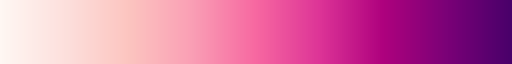

In [47]:
# Get colormap RdPu
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np

cmap = mpl.colormaps['RdPu']
cmap

/tmp/ipykernel_281344/2592050938.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


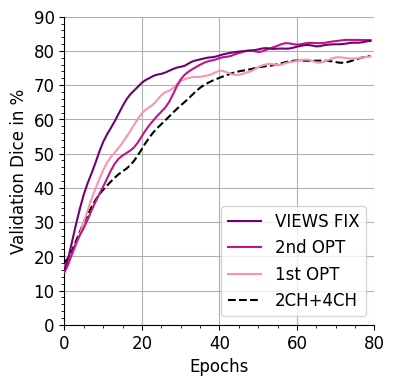

In [48]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib as mpl

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

ref_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice']*100, sigma=2)
opt_first_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-opt_first - scores/val_mean_oa_exclude_bg_dice']*100, sigma=1.2)
opt_second_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-opt_second - scores/val_mean_oa_exclude_bg_dice']*100, sigma=1.2)
opt_both_fix_smoothed = gaussian_filter1d(df['20240201__16_29_09_sleek-design_fold-1_stage-opt_both_fix - scores/val_mean_oa_exclude_bg_dice']*100, sigma=1.2)

LW = 1.5
plt.figure(figsize=(4,4))
plt.plot(opt_both_fix_smoothed, c=cmap(.9), label='VIEWS FIX', linewidth=LW, zorder=30)
plt.plot(opt_second_smoothed, c=cmap(.7), label='2nd OPT', linewidth=LW, zorder=20)
plt.plot(opt_first_smoothed, c=cmap(.4), label='1st OPT', linewidth=LW, zorder=10)
plt.plot(ref_smoothed, 'k--',label='2CH+4CH', linewidth=LW)
plt.grid(which='major')
plt.minorticks_on()
# turn outer lines off
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Dice in %')
plt.xlim([0, 80])
plt.ylim([0, 90])

plt.savefig('mmwhs_stage_dices.pdf', bbox_inches='tight')

# from scipy.interpolate import BSpline, make_interp_spline
# import numpy as np

# plt.plot(ref_smoothed, c='k', label='ref')
# # plt.show()

# # plt.plot(get_spline_of_data(df['20240201__16_29_09_sleek-design_fold-1_stage-ref - scores/val_mean_oa_exclude_bg_dice']*100))
# # plt.show()